# Convolutional Neural Networks

In this notebook we're going to explore handwritten digit recognition task using MNIST database and CNNs

In [50]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Set style

In [51]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Just for the sake of reproducibility

In [52]:
np.random.seed(41)

# Data

In this tutorial we're going to use MNIST dataset with handwritten digits.

## MNIST overview

Let's download MNIST dataset. There is a special function in Keras for that purpose (because MNIST is extremely popular)

In [53]:
# load MNIST data
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
img_rows, img_cols = 28, 28
number_of_classes = 10
print(f"X before flatten train      shape: {X_train.shape}")
print(f"X before flatten validation shape: {X_valid.shape}")
print(f"X before flatten test       shape: {X_test.shape}")

X before flatten train      shape: (48000, 28, 28)
X before flatten validation shape: (12000, 28, 28)
X before flatten test       shape: (10000, 28, 28)


In [54]:
X_train.shape

(48000, 28, 28)

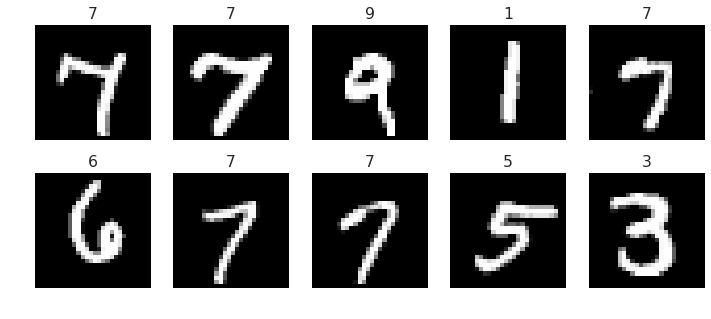

In [55]:
plt.figure(figsize=(12, 5))
for num, i in enumerate(np.random.choice(len(X_train), 10)):
    plt.subplot(2, 5, num + 1)
    plt.imshow(X_train[i], cmap="Greys_r")
    plt.axis("off")
    plt.title(str(y_train[i]))

Let's see objects are distributed among classes

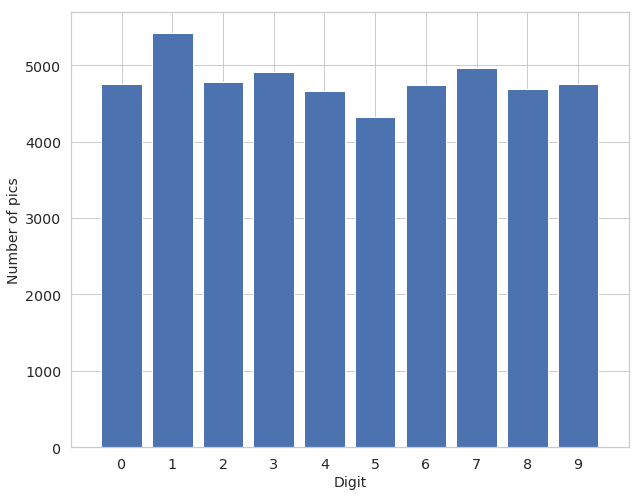

In [56]:
x_bars, y_bars = np.unique(y_train, return_counts=True)
plt.bar(x_bars, y_bars)
plt.xlim([-1, 10])
plt.xticks(np.arange(0, 10))
plt.xlabel("Digit", fontsize=14)
plt.ylabel("Number of pics", fontsize=14)
plt.show()

As one can see, the task is pretty balanced

## Data preparation

First of all, let's predefine image parameters:
* **img_rows, img_cols** $-$ 2D dimension of a pictures; for MNIST it is $28 \times 28$
* **nb_classes** $-$ number of classes (digits in our case)

In [57]:
img_rows, img_cols = 28, 28
nb_classes = 10

Theano and Tensorflow both are tensor-based libraries. It means that all objects inside it, all inputs and outputs are **tensors**. One can treat tensor as a simple multidimensional array.

The thing that is different in Theano and Tensorflow is order of these dimensions inside tensor.

With Theano yo're going to have 4-dimensional tensor with the following dimensions: **(Objects, Channels, Image rows,Image columns)**. Assume that $\text{X_train}$ is our tensor. Then $\text{X_train}[0]$ gives you one trainig object - it is an image with few channels in general case. $\text{X_train}[0][0]$ gives you the first channel of the first object. And so on. The logic of tensors should be clear now.

In Tensorflow the order is the following: **(Objects, Image rows,Image columns, Channels)**

Thus we need to check what dimension order do we have and reshape our tensor in accordance with it:

In [58]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Here we have grayscale image and thus the number of the channels is $1$. Here I used Tensorflow library with the corresponding order of dimensions

In [59]:
print('X_train shape:', X_train.shape)

X_train shape: (48000, 28, 28, 1)


Tensorflow prefers to work with $\text{float32}$ data type. So the next step is to cast data. Also let's have our data in $[0; 1]$ interval $-$ it's common choice for grayscale images.

In [60]:
#Here we're going to use dense baseline models so we need to represent our data as 1-dimensional vectors
#So we flatten input images to 1D vectors 
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)

# Tensorflow/Keras prefers to work with float32 data type. 
# So the next step is to cast data. 
# Also let's have our data in [0; 1]interval; it's common choice for grayscale images.

X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255
print(f"X train      shape: {X_train.shape}, {y_train.shape}")
print(f"X validation shape: {X_valid.shape},  {y_valid.shape}")
print(f"X test       shape: {X_test.shape},  {y_test.shape}")
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

X train      shape: (48000, 784), (48000,)
X validation shape: (12000, 784),  (12000,)
X test       shape: (10000, 784),  (10000,)


## Setup the MNIST data
Setup the MNIST data. Here we use  **digits 0 to 9**. 

Convert labels into [One-Hot Encoding](https://en.wikipedia.org/wiki/One-hot) because we're going to learn them through the softmax layer of CNN

In [61]:
y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)
y_test  = to_categorical(y_test, nb_classes)

In [62]:
print(f"X train      shape: {X_train.shape}, {y_train.shape}")
print(f"X validation shape: {X_valid.shape},  {y_valid.shape}")
print(f"X test       shape: {X_test.shape},  {y_test.shape}")

X train      shape: (48000, 784), (48000, 10)
X validation shape: (12000, 784),  (12000, 10)
X test       shape: (10000, 784),  (10000, 10)


# Baseline model: Dense MLP model

First of all, let's build MLP model as a baseline and see how it performs.

In [63]:
model_dense = Sequential()

In [64]:
model_dense.add(Dense(128, input_shape=(img_rows * img_cols,), activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(128, activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(128, activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(nb_classes, activation="softmax"))

Our model the the following architercture

In [65]:
model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total para

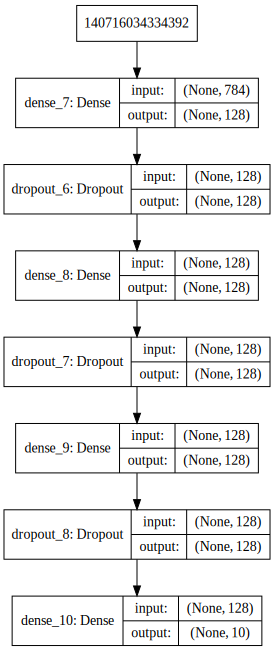

In [66]:
SVG(model_to_dot(model_dense, show_shapes=True).create(prog='dot', format='svg'))

Compile model

In [67]:
model_dense.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

## Training

In [68]:
import time
start = time.time()
epochs=20
hist = model_dense.fit(X_train.reshape((len(X_train), img_cols * img_rows)), y_train, 
                       validation_data = (X_valid, y_valid), 
                       epochs=epochs, batch_size=128)
end = time.time()
seconds_per_epoch = f"{(end - start)/epochs:.4}"
print(f"seconds_per_epoch: {seconds_per_epoch}")


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 3s 64us/step - loss: 1.5363 - acc: 0.4403 - val_loss: 4.6569 - val_acc: 0.6965
Epoch 2/20
48000/48000 [==============================] - 2s 52us/step - loss: 0.8265 - acc: 0.7203 - val_loss: 4.0549 - val_acc: 0.7403
Epoch 3/20
48000/48000 [==============================] - 2s 51us/step - loss: 0.6459 - acc: 0.7999 - val_loss: 3.7781 - val_acc: 0.7598
Epoch 4/20
48000/48000 [==============================] - 2s 52us/step - loss: 0.5500 - acc: 0.8373 - val_loss: 3.0322 - val_acc: 0.8071
Epoch 5/20
48000/48000 [==============================] - 3s 52us/step - loss: 0.4960 - acc: 0.8552 - val_loss: 2.5715 - val_acc: 0.8367
Epoch 6/20
48000/48000 [==============================] - 2s 52us/step - loss: 0.4557 - acc: 0.8674 - val_loss: 2.2560 - val_acc: 0.8575
Epoch 7/20
48000/48000 [==============================] - 3s 57us/step - loss: 0.4228 - acc: 0.8779 - val_loss: 2.0098 - val_acc

## Evaluation

In [69]:
# Returns the loss value & metrics values for the model in test mode.
# CXE and accuracy
model_dense.evaluate(X_test,  y_test, verbose=1)

10000/10000 [==============================] - 0s 36us/step


[0.17201692529022694, 0.9501]

###  Visualize the learning, epoch by epoch

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 1.0, 'Accuracy')

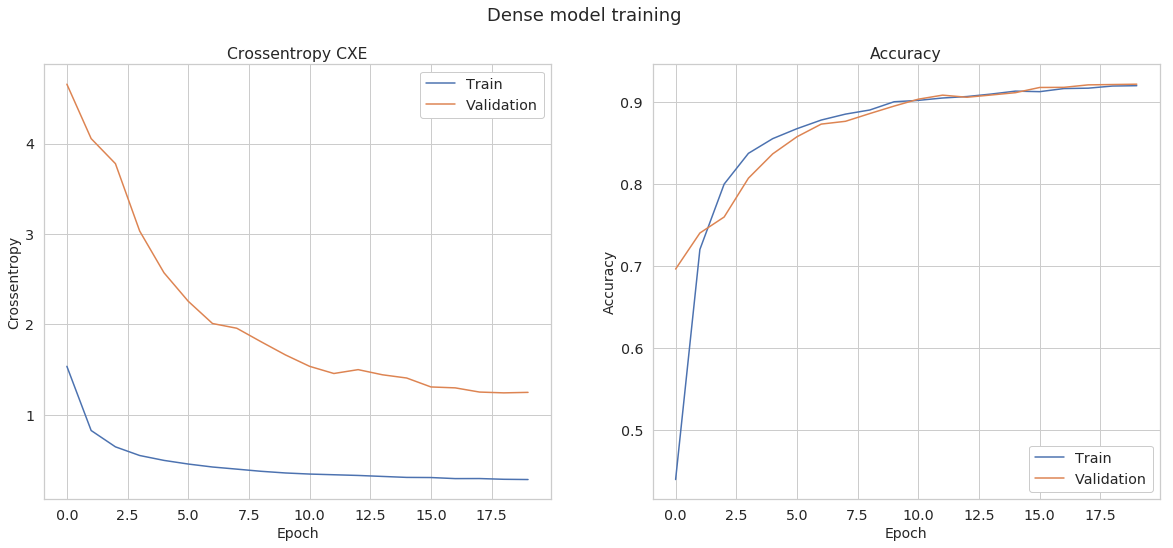

In [70]:
plt.figure(figsize=(20, 8))
plt.suptitle("Dense model training", fontsize=18)
plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Validation")
plt.grid("on")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend(loc="upper right")
plt.title("Crossentropy CXE")
plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.grid("on")
plt.plot(hist.history["val_acc"], label="Validation")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.title("Accuracy")

#plt.ylim([0.88, 1.0]);

Table to store the results of the experiments

In [71]:


expLog

,exp_name,epoch (secs),Epochs,Train CXE Loss,Train Acc,Validation CXE Loss,Validation Acc,Test CXE Loss,Test Accuracy


### Debugging (please use)

In [2]:
x = 3 
y =4

from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit         

print(f"x: {x}")


--Return--
None
> <ipython-input-2-79bc8a8de89f>(4)<module>()
      2 y =4
      3 
----> 4 from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit
      5 
      6 print(f"x: {x}")

ipdb> l
      1 x = 3
      2 y =4
      3 
----> 4 from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit
      5 
      6 print(f"x: {x}")

ipdb> x
3
ipdb> n
> /usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py(3270)run_code()
   3268             finally:
   3269                 # Reset our crash handler in place
-> 3270                 sys.excepthook = old_excepthook
   3271         except SystemExit as e:
   3272             if result is not None:

ipdb> q


BdbQuit: 

In [1]:
# add the result of this experiment to the log book
exp_name = "MLP-784-128-128-128-10" # experiment name
#del expLog
try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name", "epoch (secs)", "Epochs", "Train CXE Loss", "Train Acc", "Validation CXE Loss", "Validation  Acc",
                    "Test CXE Loss", "Test  Accuracy"])
    
# Add a experiment results to the experiment log
model = model_dense
#from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit         
expLog.loc[len(expLog)] = [f"{exp_name}", seconds_per_epoch, epochs] + list(np.round(np.reshape([model.evaluate(X_train, y_train, verbose=0), 
                   model.evaluate(X_valid, y_valid, verbose=0),
                   model.evaluate(X_test,  y_test, verbose=1)], -1), 3))
expLog

NameError: name 'pd' is not defined

## Task 3.1 : choose a better MLP architecture



Using all the training data, search for a good CNN architecture to model the MNIST problem. Above we explored 784-128-128-128-10.
 

It is up to you what the model will be. Here are some things you need to decide:
1. how many DENSE layers?
* how manu neurons per layer
* report the accuracy on the test data set

Please use use like this to explore different architectures:


```python
model_dense = Sequential()  #784-12-12-10
model_dense.add(Dense(12, input_shape=(img_rows * img_cols,), activation="relu"))
model_dense.add(Dense(12, activation="relu"))
model_dense.add(Dense(nb_classes, activation="softmax"))

# E.g., explore 24 possible architectures 
number_of_hidden_layes = [1, 2, 3, 4]
number_of_hidden_nodes = [12, 24, 48, 96, 128,256]


```


**Please paste your response here using the following format:** 
* Best archtecture is:  
* Test accuracy: 
* Training time per epoch in seconds is : 


## Task 3.2 : with 500 training examples

Use only 500 examples per class (recall we  have only 10 classes) and find the best architecture. 
HINTs:
* you can do  stratified sampling OR just random selection of 5,000 examples
* for inspiration, see [here](https://mclguide.readthedocs.io/en/latest/sklearn/multiclass.html)
* For more details see: [sklearn.model_selection.train_test_split manual page](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
  * `stratify` : array-like or None (default=None)
    If not None, data is split in a stratified fashion, using this as the class labels.

```python
# load MNIST data
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                     test_size=55000./60000., random_state=42, 
                                                     stratify=y_train)
img_rows, img_cols = 28, 28
number_of_classes = 10
print(f"X before flatten train      shape: {X_train.shape}")
print(f"X before flatten validation shape: {X_valid.shape}")
print(f"X before flatten test       shape: {X_test.shape}")
print(f"All data: {np.bincount(y_train) / float(len(y_train))}")
```

**Please paste your response here:** 
* Best archtecture is:  
* Test accuracy: 
* Training time per epoch in seconds is : 

## Task 3.3 : Odd versus Even Classifier

Build a binary classifier that classifiers odd numbers versus even numbers. Again, try to find the best architecture.


**Please paste your response here:** 
* Best archtecture is:  
* Test accuracy: 
* Training time per epoch in seconds is : 


## 3.4 Homework Submission Instructions:



1. Please fill in your best architecture for each of the three homework tasks 3.1, 3.2, 3.3: 
https://docs.google.com/spreadsheets/d/11Ot_v7EKmBoNgXBEjCsN_S7tYtfa5OXFLQoH62JCf1g/edit?usp=sharing
  * NOTE: that each task has a SEPARATE table/tab in the above spreadsheet.
  * The winner in each task gets a special prize!
* Please upload your notebook to the following Google Drive folder (you save directly or just can drag and drop):
  * https://drive.google.com/drive/folders/18Ng3PfnVBhrT82s_rQ_-WylE5rN7f9ej?usp=sharing
* Your homework submission is now due tomorrow (Thursday) morning at 8AM (that will give you an extra 12 hours!!)
* Please send the following by EMAIL to James.Shanahan@gmail.com with the subject "Sichuan2019: MNIST Best MLP Architecture"

  * Link to your own Google Colab notebook where you did the experiments
  * All the text + your response from this cell
  * A screenshot of your expLog table

# Building CNN model

## Load MNIST data

In [74]:
# load MNIST data
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
img_rows, img_cols = 28, 28
number_of_classes = 10
print(f"X before flatten train      shape: {X_train.shape}")
print(f"X before flatten validation shape: {X_valid.shape}")
print(f"X before flatten test       shape: {X_test.shape}")

#Tensorflow prefers to work with float32 data type. 
#So the next step is to cast data. 
# Also let's have our data in [0; 1]interval; it's common choice for grayscale images.

X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255
print(f"X train      shape: {X_train.shape}, {y_train.shape}")
print(f"X validation shape: {X_valid.shape},  {y_valid.shape}")
print(f"X test       shape: {X_test.shape},  {y_test.shape}")

X before flatten train      shape: (48000, 28, 28)
X before flatten validation shape: (12000, 28, 28)
X before flatten test       shape: (10000, 28, 28)
X train      shape: (48000, 28, 28), (48000,)
X validation shape: (12000, 28, 28),  (12000,)
X test       shape: (10000, 28, 28),  (10000,)


### Input image Data reshaping and expanding 28x28x1

First of all, let's predefine image parameters:
* **img_rows, img_cols** $-$ 2D dimension of a pictures; for MNIST it is $28 \times 28$
* **nb_classes** $-$ number of classes (digits in our case)

In [75]:
img_rows, img_cols = 28, 28
nb_classes = 10

Tensorflow, pyTorch, Theano (no longer used) principal data data structure is a tensor, which is essentially a multidimensional array data structure.  All data, models, all inputs and outputs are represented as **tensors**. 

Tensorflow supports different dimension orders inside a tensor for image data in particular, which is visible via a call to Keras backend via `K.image_data_format()`. It supports two formats `channels_first` (channel, row, column), and `channels_last` (row, column, channel). These correspond to ordering for Theano and Tensorflow style tensors respectively. One can change the ordering setting as follows to `channels_last` the default setting for Tensorflow: 
```python 
K.set_image_data_format('channels_last')
```  

If the `K.image_data_format()` is set to `channels_first` (i.e., the Theano tensor format) data tensors for images will be 4-dimensional in nature: **(Objects, Channels, Image rows,Image columns)**. Assume that $\text{X_train}$ is the input image training  tensor. Then $\text{X_train}[0]$ gives you one training object - it is an image with a few channels in the general case. $\text{X_train}[0][0]$ gives you the first channel of the first object, $\text{X_train}[0][1]$ gives you the second channel (if it exists),  and so on. 

In Tensorflow the order for an input image data tensor is as follows: **(Objects, Image rows,Image columns, Channels)**

When working with Keras, one can cross check the tensor dimension order for the Tensorflow backend to avoid any surprises and reshape and expand the grayscale image data as follows (here imagine we are using the  MNIST digits data here):

```python
import numpy as np
import pandas as pd
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
img_rows, img_cols = 28, 28
number_of_classes = 10

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    X_test  = X_test.reshape( X_test.shape[0],  1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
```    

In [76]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    X_test  = X_test.reshape( X_test.shape[0],  1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

### Setup the MNIST Target data (OHE)
Setup the MNIST data. Here we use  **digits 0 to 9**. 

Convert labels into [One-Hot Encoding](https://en.wikipedia.org/wiki/One-hot) because we're going to learn them through the softmax layer of CNN

In [77]:
y_train = to_categorical(y_train, number_of_classes)
y_valid = to_categorical(y_valid, number_of_classes)
y_test  = to_categorical(y_test, number_of_classes)

In [78]:
print(f"X train      shape: {X_train.shape}, {y_train.shape}")
print(f"X validation shape: {X_valid.shape},  {y_valid.shape}")
print(f"X test       shape: {X_test.shape},  {y_test.shape}")

X train      shape: (48000, 28, 28, 1), (48000, 10)
X validation shape: (12000, 28, 28, 1),  (12000, 10)
X test       shape: (10000, 28, 28, 1),  (10000, 10)


## Lay out the CNN Architecture

Now it's time to build the model step-by-step

In [79]:
model_cnn = Sequential()

Out model is going to be *Sequential* which means that every new added layer will be automatically connected to the previous one.

Firstly, let's define hyperparameters of the network:
* **filters** $-$ number of filters (or kernels) to use in every layer; in fact this is the same as having multiple channels in the image
* **pool_size** $-$ size of the pooling window
* **kernel_size** $-$ size of the convolutional filters

In [80]:
filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

Now let's add first layer of the network. It is 2D Convolutional layer. Only unexplained thing here is *padding*. This is the parameter that defines how should we pad the data after applying convolutions. $\text{padding} = \text{'valid'}$ means that we're not going to pad images and the dimension of it is going to shrink from layer to layer.

In [81]:
model_cnn.add(Convolution2D(filters=filters, 
                            kernel_size=kernel_size,
                            padding="valid",
                            input_shape=input_shape))

Next step is to add nonlinearity to enable our network to learn complex dependencies. We're going to use ReLU activation function because it is less exposed to vanishing gradient problem and faster to train.

In [82]:
model_cnn.add(Activation('relu'))

Let's stack one more Convolution layer on top of that:

In [83]:
model_cnn.add(Convolution2D(filters=filters, 
                            kernel_size=kernel_size,
                            padding="valid"))
model_cnn.add(Activation('relu'))

Now it's time to apply pooling. Note that the strategies of combining convolutional and pooling layers may be different. For further details see [here](http://cs231n.stanford.edu/)

In [84]:
model_cnn.add(MaxPooling2D(pool_size=pool_size))

At this point we consider that we've already distinguish some meaningful features from the pictures. So it's time to classify them. For that purpose the common approach is to append fully-connected part. 

But before that we need to pull all the obtained feature into one vector so that one object has 1D-vector of features. It is done by means of $\text{Flatten}$ layer.

In [85]:
model_cnn.add(Flatten())

Now let's add FC part with the [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) to avoid overfitting.

In [86]:
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(nb_classes, activation="softmax"))

The final layer here is usual $\text{Softmax}$ with the number of classe. So as the output of the network we observe the probability of each class.

Now let's compile our model.
* **optimizer** $-$ here we use accelerated gradient descent algorithm with special adaptive way of choosing learning rate; for more details see this great [overview](http://sebastianruder.com/optimizing-gradient-descent/) of gradient descent optimization algorithms.
* **loss** $-$ usual choice for multiclass classification is softmax output layer in combination with categotical crossentropy loss function which is
$$
\mathcal{L}(\text{true}, \text{pred}) = -\sum_{j=1}^{k}\text{true}_j \cdot \log \{\text{pred}_j\}
$$
* **metrics** $-$ additional metrics that we're going to trace while training; it doesn't influence training process at all

In [87]:
model_cnn.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Let's take a look at our final model now:

In [88]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_4 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4608)              0         
__________

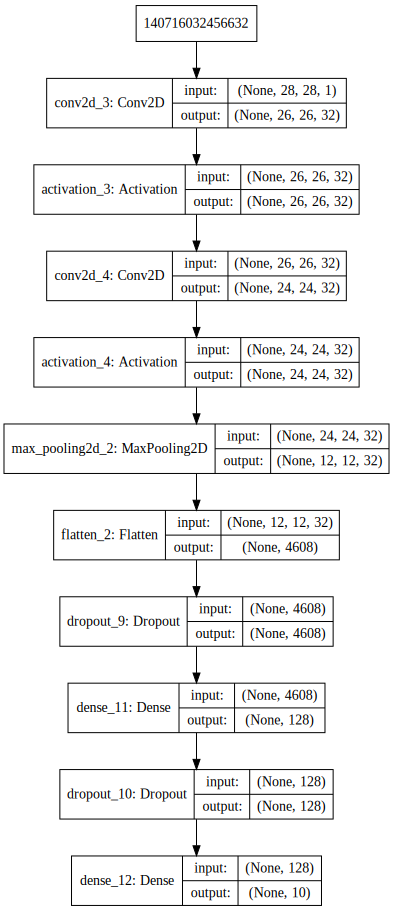

In [89]:
SVG(model_to_dot(model_cnn, show_shapes=True).create(prog='dot', format='svg'))

## Training

Training parameters are the following:
* nb_epoch $-$ number of epochs to train. here we choose 12; one may condiser using some stopping criterias
* **batch_size** $-$ parameter that controls how frequent do we update gradient; with $\text{batch_size}=1$ optimization is nothing but pure Stohastic Gradient Descent (update gradient after passing each one object); with $\text{batch_size}=\textit{number of objects}$ it will be usual Gradient Descent which updates gradient only after passing all objects. Choosing value between this two one can control speed and convergence of training process.

In [90]:
batch_size = 128
epochs = 5

Train!

In [91]:
import time
start = time.time()
hist = model_cnn.fit(X_train, y_train, 
                     batch_size=batch_size, 
                     epochs=epochs,
                     validation_data=(X_valid, y_valid))
end = time.time()
seconds_per_epoch = f"{(end - start)/epochs:.4}"
print(f"seconds_per_epoch: {seconds_per_epoch}")


Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 79s 2ms/step - loss: 0.3503 - acc: 0.8917 - val_loss: 0.0854 - val_acc: 0.9747
Epoch 2/5
48000/48000 [==============================] - 65s 1ms/step - loss: 0.1294 - acc: 0.9604 - val_loss: 0.0588 - val_acc: 0.9821
Epoch 3/5
48000/48000 [==============================] - 71s 1ms/step - loss: 0.0964 - acc: 0.9699 - val_loss: 0.0455 - val_acc: 0.9871
Epoch 4/5
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0816 - acc: 0.9753 - val_loss: 0.0432 - val_acc: 0.9870
Epoch 5/5
48000/48000 [==============================] - 60s 1ms/step - loss: 0.0713 - acc: 0.9777 - val_loss: 0.0428 - val_acc: 0.9889
seconds_per_epoch: 67.09


## Evaluation

Visualization of learning process:

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


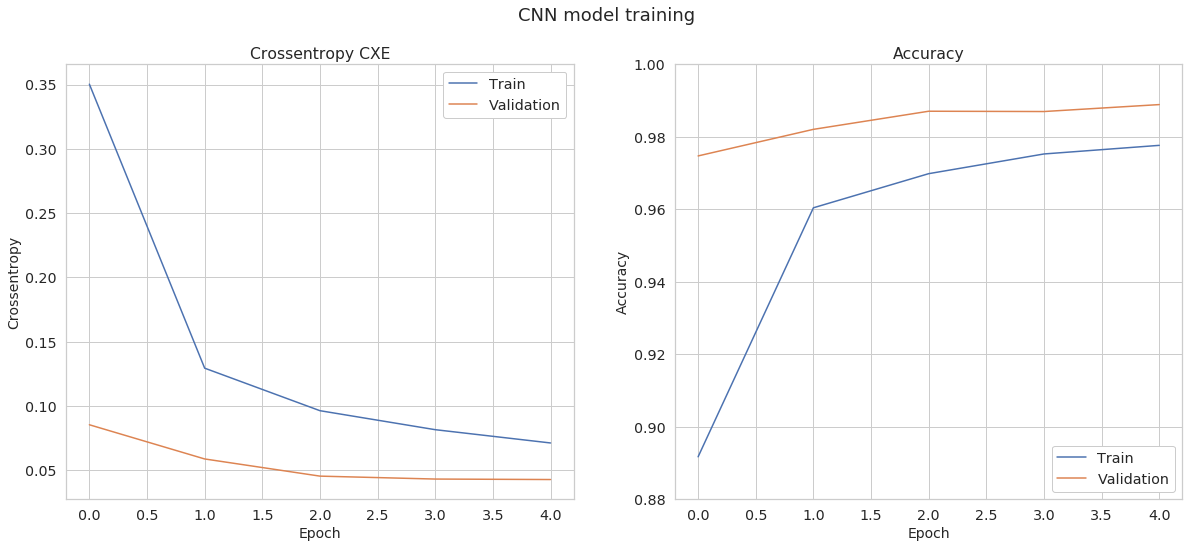

In [92]:
plt.figure(figsize=(20, 8))
plt.suptitle("CNN model training", fontsize=18)
plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Validation")
plt.grid("on")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.title("Crossentropy CXE")
plt.legend(loc="upper right")
plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.grid("on")
plt.plot(hist.history["val_acc"], label="Validation")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.title("Accuracy")
plt.ylim([0.88, 1.0]);

Final evaluation of the model:

In [93]:
# add the result of this experiment to the log book
exp_name = "CNN-784_32x3x3-32_3x3-128-10" # experiment name
try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name","epoch (secs)","Epochs","Train CXE Loss", "Train Acc", "Validation CXE Loss", "Validation  Acc",
                    "Test CXE Loss", "Test  Accuracy"])
    
# Add a experiment results to the experiment log
model = model_cnn
expLog.loc[len(expLog)] = [f"{exp_name}", seconds_per_epoch, epochs] + list(np.round(np.reshape([model.evaluate(X_train, y_train, verbose=0), 
                   model.evaluate(X_valid, y_valid, verbose=0),
                   model.evaluate(X_test,  y_test, verbose=1)], -1), 3))
expLog

10000/10000 [==============================] - 3s 292us/step


,exp_name,epoch (secs),Epochs,Train CXE Loss,Train Acc,Validation CXE Loss,Validation Acc,Test CXE Loss,Test Accuracy
0,MLP-784-128-128-128-10,2.528,20,0.146,0.957,1.248,0.922,0.172,0.950
1,MLP-784-128-128-128-10,2.528,20,0.146,0.957,1.248,0.922,0.172,0.950
2,CNN-784_32x3x3-32_3x3-128-10,67.09,5,0.028,0.991,0.043,0.989,0.037,0.988


# Task: choose a better CNN architecture


## Task 5.1 : choose a better CNN architecture

Search for a good CNN architecture to model the MNIST problem.

It is up to you what the model will be. Here are some things you need to decide:
* how many convolutional layers?
* what spatial size will your convolutions be?
* how many channels will your convolutions be?
* what nonlinearity will you use?
* will you use pooling? what type?
* how many fully-connected layers will you have?
* will you use dropout?
* what batch size?

Keras provides a special layer called `Flatten` to flatten the convolutional features into a vector before the fully-connected layers. You should look at the documentation for Keras's convolutional layers: http://keras.io/layers/convolutional/. In particular, you may want to look at `Convolution2D`, `MaxPooling2D`, `AveragePooling2D`, `Flatten`, and `Dropout`. For this problem, you make want to use the `'rmsprop'` optimizer - it is an algorithm that adapts the learning rate during learning for you automatically.



**Please paste your response here using the following format:** 
* Best archtecture is:  
* Test accuracy: 
* Training time per epoch in seconds is : 


## Task 5.2 : with 500 training examples

Use only 500 examples per class (recall we  have only 10 classes) and find the best architecture. 
HINTs:
* you can do  stratified sampling OR just random selection of 5,000 examples
* for inspiration, see [here](https://mclguide.readthedocs.io/en/latest/sklearn/multiclass.html)
* For more details see: [sklearn.model_selection.train_test_split manual page](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
  * `stratify` : array-like or None (default=None)
    If not None, data is split in a stratified fashion, using this as the class labels.

```python
# load MNIST data
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                     test_size=55000./60000., random_state=42, 
                                                     stratify=y_train)
img_rows, img_cols = 28, 28
number_of_classes = 10
print(f"X before flatten train      shape: {X_train.shape}")
print(f"X before flatten validation shape: {X_valid.shape}")
print(f"X before flatten test       shape: {X_test.shape}")
print(f"All data: {np.bincount(y_train) / float(len(y_train))}")
```

**Please paste your response here:** 
* Best archtecture is:  
* Test accuracy: 
* Training time per epoch in seconds is : 

## Task 5.3 : Odd versus Even Classifier

Build a binary classifier that classifiers odd numbers versus even numbers. Again, try to find the best architecture.


**Please paste your response here:** 
* Best archtecture is:  
* Test accuracy: 
* Training time per epoch in seconds is : 


## 5.4 Homework Submission Instructions:



1. Please fill in your best architecture for each of the three homework tasks 5.1, 5.2, 5.3: 
https://docs.google.com/spreadsheets/d/11Ot_v7EKmBoNgXBEjCsN_S7tYtfa5OXFLQoH62JCf1g/edit?usp=sharing
  * NOTE: that each task has a SEPARATE table/tab in the above spreadsheet.
  * The winner in each task gets a special prize!
* Please upload your notebook to the following Google Drive folder (you save directly or just can drag and drop):
  * https://drive.google.com/drive/folders/18Ng3PfnVBhrT82s_rQ_-WylE5rN7f9ej?usp=sharing
* Your homework submission is now due tomorrow (Friday) morning at 8AM (that will give you an extra 12 hours!!)
* Please send the following by EMAIL to James.Shanahan@gmail.com with the subject "Sichuan2019: MNIST Best MLP Architecture"

  * Link to your own Google Colab notebook where you did the experiments
  * All the text + your response from this cell
  * A screenshot of your expLog table